In [1]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  2


'/device:GPU:0'

In [3]:
# Paths to data
path_single = r"/kaggle/input/landslide4sense/TrainData/img/image_1.h5"
path_single_mask = r'/kaggle/input/landslide4sense/TrainData/mask/mask_1.h5'
TRAIN_PATH = r"/kaggle/input/landslide4sense/TrainData/img/*.h5"
TRAIN_MASK = r'/kaggle/input/landslide4sense/TrainData/mask/*.h5'

Input data shape: (128, 128, 14)
Data NDVI shape: (128, 128) F_data shape: (1, 128, 128, 3)
Mask data shape: (128, 128)


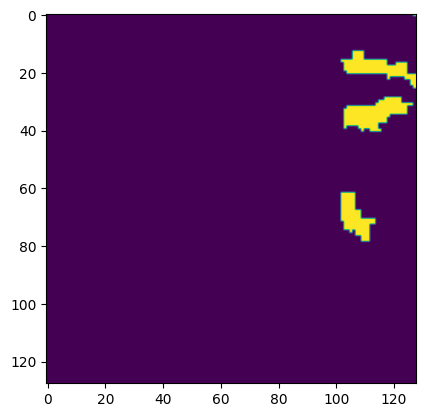

In [4]:
# Test single data file
f_data = np.zeros((1, 128, 128, 3))
with h5py.File(path_single) as hdf:
    data = np.array(hdf.get('img'))
    print("Input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])
    
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))
    f_data[0, :, :, 0] = data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]
    print("Data NDVI shape:", data_ndvi.shape, "F_data shape:", f_data.shape)
    plt.imshow(data_ndvi)

with h5py.File(path_single_mask) as hdf:
    data = np.array(hdf.get('mask'))
    print("Mask data shape:", data.shape)
    plt.imshow(data)

In [5]:
# Load all training data
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))
TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))

epsilon = 1e-7  # Small value to prevent division by zero

for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    with h5py.File(img) as hdf:
        data = np.array(hdf.get('img'))
        data[np.isnan(data)] = epsilon

        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red) + epsilon)
        
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi  # NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / (mid_slope + epsilon)  # SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / (mid_elevation + epsilon)  # ELEVATION
    
    with h5py.File(mask) as hdf:
        data = np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

TRAIN_XX[np.isnan(TRAIN_XX)] = epsilon
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


In [6]:
# Define metrics
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [7]:
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle=True)
del TRAIN_XX, TRAIN_YY, all_train, all_mask

In [8]:
# Define U-Net model
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    
    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

model = unet_model(128, 128, 6)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 6)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            880 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,537 (7.41 MB)

 Trainable params: 1,941,537 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

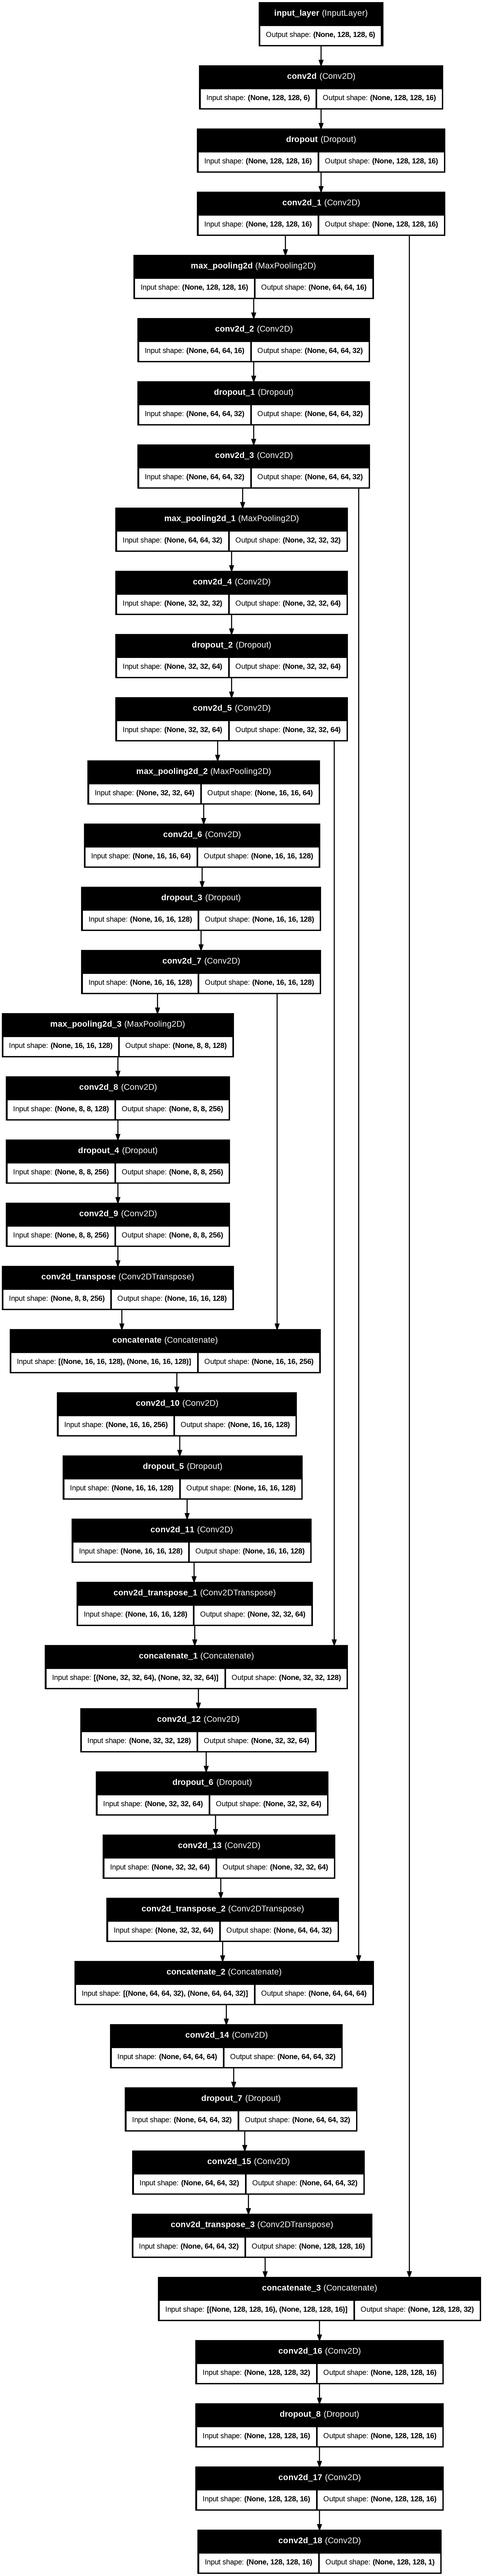

In [9]:
#Model Visualization
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

In [10]:
# Define callbacks
checkpointer = ModelCheckpoint("best_model.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
earlyStopping = EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')
callbacks = [earlyStopping, checkpointer]

In [11]:
# Train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, verbose=2, validation_data=(x_valid, y_valid), callbacks=callbacks)

Epoch 1/100

Epoch 1: val_f1_m improved from -inf to 0.52340, saving model to best_model.keras
190/190 - 46s - 242ms/step - accuracy: 0.9773 - f1_m: 0.0991 - loss: 0.0667 - precision_m: 0.5350 - recall_m: 0.0719 - val_accuracy: 0.9830 - val_f1_m: 0.5234 - val_loss: 0.0438 - val_precision_m: 0.6341 - val_recall_m: 0.4669
Epoch 2/100

Epoch 2: val_f1_m improved from 0.52340 to 0.57983, saving model to best_model.keras
190/190 - 7s - 39ms/step - accuracy: 0.9827 - f1_m: 0.5466 - loss: 0.0483 - precision_m: 0.7118 - recall_m: 0.4728 - val_accuracy: 0.9805 - val_f1_m: 0.5798 - val_loss: 0.0469 - val_precision_m: 0.5263 - val_recall_m: 0.6784
Epoch 3/100

Epoch 3: val_f1_m improved from 0.57983 to 0.61555, saving model to best_model.keras
190/190 - 7s - 39ms/step - accuracy: 0.9843 - f1_m: 0.5975 - loss: 0.0427 - precision_m: 0.7304 - recall_m: 0.5282 - val_accuracy: 0.9865 - val_f1_m: 0.6156 - val_loss: 0.0356 - val_precision_m: 0.7224 - val_recall_m: 0.5475
Epoch 4/100

Epoch 4: val_f1_m i

In [12]:
# Save the final model
model.save("model_save.keras")

In [13]:
# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}, F1 Score: {f1_score}, Precision: {precision}, Recall: {recall}")

Loss: 0.0286190677434206, Accuracy: 0.9890566468238831, F1 Score: 0.7012050747871399, Precision: 0.7905611395835876, Recall: 0.6338011622428894


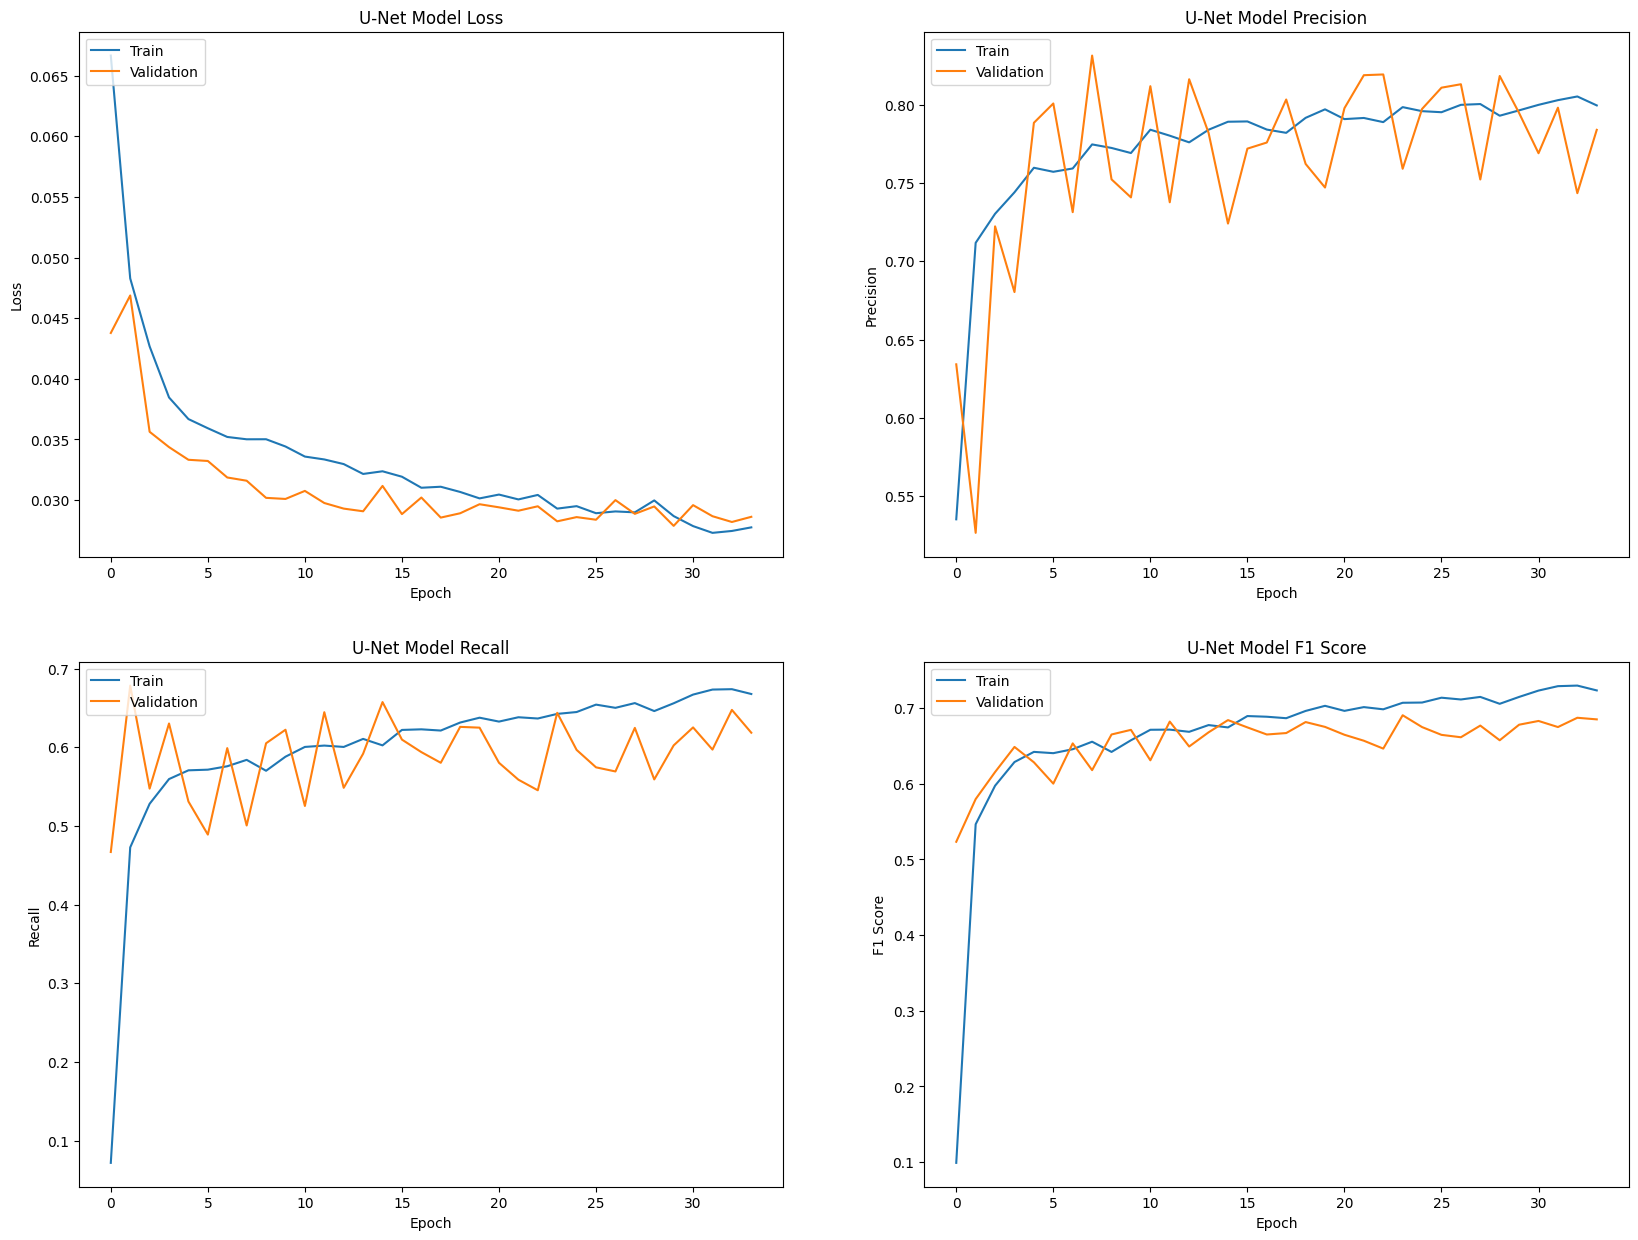

In [14]:
# Plot training history
fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('U-Net Model Loss')
ax11.set_ylabel('Loss')
ax11.set_xlabel('Epoch')
ax11.legend(['Train', 'Validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('U-Net Model Precision')
ax12.set_ylabel('Precision')
ax12.set_xlabel('Epoch')
ax12.legend(['Train', 'Validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('U-Net Model Recall')
ax13.set_ylabel('Recall')
ax13.set_xlabel('Epoch')
ax13.legend(['Train', 'Validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('U-Net Model F1 Score')
ax14.set_ylabel('F1 Score')
ax14.set_xlabel('Epoch')
ax14.legend(['Train', 'Validation'], loc='upper left')

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


Text(0.5, 1.0, 'Training Image')

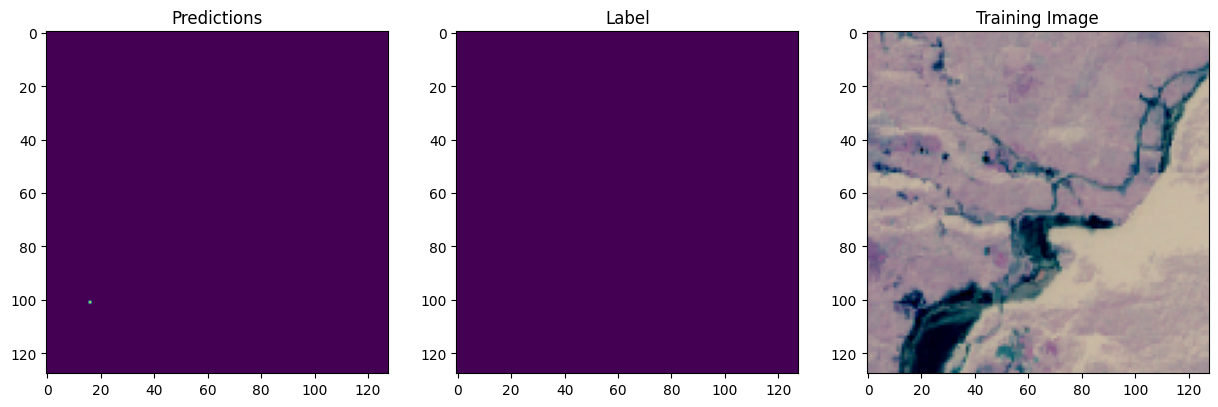

In [15]:
# Predict on validation data
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)
img = 155
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

In [16]:
# Load and preprocess validation data
validation_url = r'/kaggle/input/landslide4sense/ValidData/img/*.h5'
img_val = sorted(glob.glob(validation_url))
VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []

epsilon = 1e-7  # Small value to prevent division by zero

for i, img in enumerate(img_val):
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        data = np.array(hdf.get('img'))
        data[np.isnan(data)] = epsilon

        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red) + epsilon)
        
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # BLUE
        VAL_XX[i, :, :, 3] = data_ndvi  # NDVI
        VAL_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope  # SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation  # ELEVATION

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step


Text(0.5, 1.0, 'Training Image')

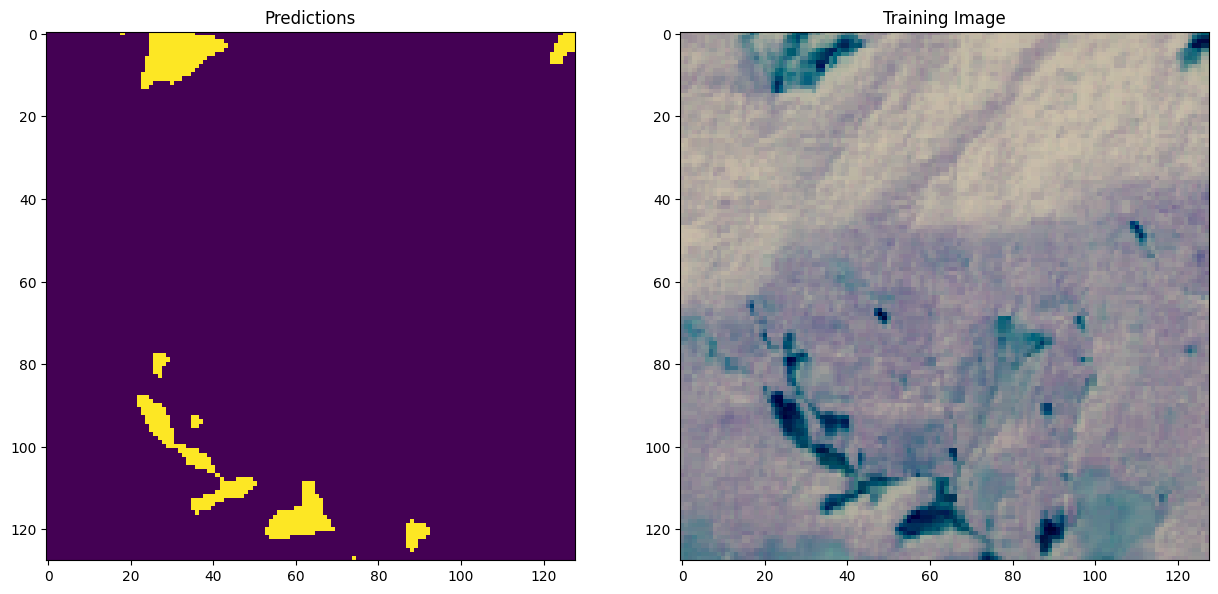

In [17]:
# Predict on validation data
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
img = 167
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

In [18]:
#Saving predicted segmentation masks for validation data in HDF5 format
import os
import h5py

write_directory = r'/kaggle/working/validation/mask'

# Ensure the directory exists
os.makedirs(write_directory, exist_ok=True)

for i, name in enumerate(mask_name):
    file_path = os.path.join(write_directory, name) 
    
    with h5py.File(file_path, 'w') as h5f: 
        pred_mask = pred_img[i, :, :, 0] 
        h5f.create_dataset('mask', data=pred_mask)